In [2]:
import stacrs
import pystac
from odc.stac import load

url = "https://data.source.coop/ausantarctic/ghrsst-mur-v2/ghrsst-mur-v2.parquet"

center = 13, -61
buffer = 5

bbox = (
    center[1] - buffer,
    center[0] - buffer,
    center[1] + buffer,
    center[0] + buffer,
)

items = await stacrs.read(url)  # Or use .search to filter
items = [pystac.Item.from_dict(i) for i in items["features"]]

In [3]:
data = load(
    items,
    bbox=bbox,
    chunks={},
    measurements=["analysed_sst"],
    fail_on_error=False,
)
data

<xarray.Dataset> Size: 17GB
Dimensions:       (latitude: 1001, longitude: 1001, time: 8327)
Coordinates:
  * latitude      (latitude) float64 8kB 18.0 17.99 17.98 ... 8.02 8.01 8.0
  * longitude     (longitude) float64 8kB -66.0 -65.99 -65.98 ... -56.01 -56.0
    spatial_ref   int32 4B 4326
  * time          (time) datetime64[ns] 67kB 2002-06-01 ... 2025-03-19
Data variables:
    analysed_sst  (time, latitude, longitude) int16 17GB dask.array<chunksize=(1, 1001, 1001), meta=np.ndarray>

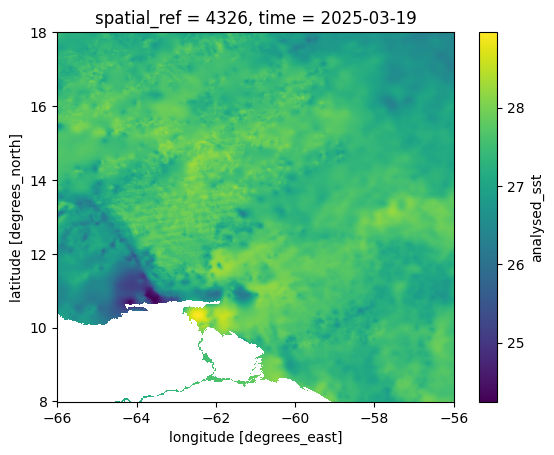

In [ ]:
sst_bands = items[0].assets["analysed_sst"].extra_fields["raster:bands"]
sst_scale = sst_bands[0]["scale"]
sst_offset = 25  # Go to celcius  

# Mask nodata
sst = data.analysed_sst.where(data.analysed_sst != data.analysed_sst.odc.nodata)

# Apply the scale and offset to the data
sst_scaled = (sst * sst_scale) + sst_offset

sst_scaled.isel(time=-1).plot.imshow()

/opt/homebrew/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/opt/homebrew/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
Ignoring read failure while reading: https://data.source.coop/ausantarctic/ghrsst-mur-v2/2020/12/12/20201212090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_analysed_sst.tif:1


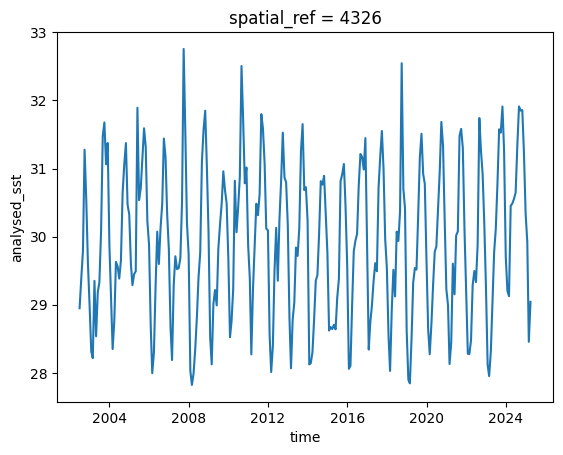

In [12]:
from distributed import Client

# Create a dask client with 8 processes each with 8 threads
with Client(n_workers=4, threads_per_worker=16):
    # sample = sst_scaled.sel(time=slice("2021-01-01", "2024-12-31"))
    # Calculate the max value for each month over time
    monthly_max = sst_scaled.resample(time="1ME").max()
    # Now work out the max for all the x/y and plot a single line graph
    monthly_max.max(dim=["longitude", "latitude"]).plot.line()
